In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Load dataset

In [2]:
# Load datasets
source="./airbnb_data/"
calendar=pd.read_csv(source+"calendar.csv")
listings=pd.read_csv(source+"listings.csv")

In [3]:
calendar.head()

,listing_id,date,available,price,metro_area
0,2515,2018-03-05,t,69.0,NYC
1,2515,2018-03-04,t,69.0,NYC
2,2515,2018-03-03,t,69.0,NYC
3,2515,2018-03-02,t,69.0,NYC
4,2515,2018-03-01,t,69.0,NYC


## Clean dataset
### 1) Filter and clean data of interest

In [4]:
print(calendar['metro_area'].unique().tolist())

['NYC', 'denver', 'chicago', 'boston', 'dc']


In [5]:
# Filter only NYC data
calendar = calendar[calendar['metro_area']=='NYC']

# In 'available' column, change true to 1 and false to 0
calendar['available'] = calendar['available'].apply(lambda x:1 if x == 't' else 0)

# Convert date column to data type date
calendar['date'] = pd.to_datetime(calendar['date'])

calendar.head()

,listing_id,date,available,price,metro_area
0,2515,2018-03-05,1,69.0,NYC
1,2515,2018-03-04,1,69.0,NYC
2,2515,2018-03-03,1,69.0,NYC
3,2515,2018-03-02,1,69.0,NYC
4,2515,2018-03-01,1,69.0,NYC


### 2) Create table of available days by month and listing

In [6]:
# Find start_date for dataset of each listing
# start_date = calendar.groupby('listing_id')['date'].min().to_frame()
# start_date = start_date.reset_index()
# start_date.head()

# We can check that all the start dates are in May 2017
# np.mean(start_date['date'].dt.month)

In [26]:
# Sum total number of days in a month with data and number of days which listing is available for
availability = calendar.groupby([pd.Grouper(key='date',freq='M'),'listing_id'])['available'].agg(['sum','count']).reset_index()
availability['booked_days'] = availability['count'] - availability['sum']
availability = availability.rename({'sum':'available_days','count':'total_days'}, axis=1)
availability.head()

,date,listing_id,available_days,total_days,booked_days
0,2017-05-31,2515,5,30,25
1,2017-05-31,2595,30,30,0
2,2017-05-31,3647,30,30,0
3,2017-05-31,3831,0,30,30
4,2017-05-31,4611,4,30,26


In [13]:
len(availability)

529789

### 3) Focus on listings & months with low booking rate
We find that a significant percentage of listings and months are available for almost a full month. That is, the listings are shown as available on the calendar on Airbnb but are not booked at all/have extremely low booking rates. We choose to focus on examining why by exploring their characteristics and identifying patterns.

In [27]:
# Number of unique listing ids in dataset
print("Number of unique listings: {}".format(len(availability['listing_id'].unique().tolist())))

# Percentage of listing months which have 0 booking days
print("% of listing-months with zero bookings: {}".format(len(availability[availability['booked_days'] == 0])/len(availability)*100))

# Create dataset of high-availability months and listings
no_booking = availability[availability['booked_days']==0]
print("Ave # months/listing with zero bookings: {}".format(len(no_booking)/len(no_booking['listing_id'].unique().tolist())))

Number of unique listings: 40753
% of listing-months with zero bookings: 29.887936518123254
Ave # months/listing with zero bookings: 6.929368517789156


In [28]:
no_booking.head()

,date,listing_id,available_days,total_days,booked_days
1,2017-05-31,2595,30,30,0
2,2017-05-31,3647,30,30,0
7,2017-05-31,5121,30,30,0
47,2017-05-31,11943,29,29,0
51,2017-05-31,12303,29,29,0


In [29]:
len(no_booking['listing_id'].unique().tolist())

22851

### 4) Create dataset with unique listings and adjustment factor
Since the data ends sometime in May 2018, the count of frequency based on booked_days = 0 may result in an additional month being counted. We calculate an adjustment factor, which is 1 if a month needs to be deducted from the frequency, and 0 if no deduction needs to be made. The adjustment factor is 1 when booked_days = 0 in BOTH May 2017 and May 2018.

In [46]:
may_data = no_booking[no_booking['date'].dt.month == 5]
may_data = may_data.groupby('listing_id')['booked_days'].sum().reset_index()
may_data.head()

,listing_id,booked_days
0,2515,0
1,2595,0
2,3647,0
3,3831,0
4,4611,0


In [92]:
adjustment = pd.DataFrame(no_booking['listing_id'].unique())
adjustment = adjustment.rename({0:'listing_id'},axis=1)
adjustment['factor'] = may_data['booked_days'].apply(lambda x:1 if x==0 else 0)
adjustment['factor'] = adjustment['factor'].fillna(0)
adjustment.head()

,listing_id,factor
0,2595,1.0
1,3647,1.0
2,5121,1.0
3,11943,1.0
4,12303,1.0


### 5) Create dataset of unique high-availability listings with count of months

In [93]:
print(len(no_booking))
print(len(no_booking['listing_id'].unique().tolist()))

158343
22851


In [94]:
# Listings with zero-booking months (non-unique listings)
no_booking_mth = no_booking.drop(['available_days','booked_days','total_days','date'], axis=1)
no_booking_mth.head()

,listing_id
1,2595
2,3647
7,5121
47,11943
51,12303


In [95]:
# Add column of frequency i.e. number of zero-booking months per unique listing
no_booking_mth['no_months'] = no_booking_mth['listing_id'].map(no_booking_mth['listing_id'].value_counts())

# Merge no_booking_mth with adjustment
no_booking_mth = no_booking_mth.merge(adjustment, on='listing_id', how='inner')

# Calculate actual number of months and remove adjustment row
no_booking_mth['no_months'] = no_booking_mth['no_months']-no_booking_mth['factor']
no_booking_mth = no_booking_mth.drop('factor',axis=1)
no_booking_mth.no_months = no_booking_mth.no_months.astype(int)
no_booking_mth.head()

,listing_id,no_months
0,2595,12
1,2595,12
2,2595,12
3,2595,12
4,2595,12


In [97]:
# Check that number of unique listings matches that in low_occ table
print(len(no_booking_mth))

158343


We plot a histogram of the zero-booking months and see that a significant number of unique listings have a full year of zero-booking months. There could be various reasons why these listings are experiencing a full year of zero bookings. Possible reasons:  
1) The quality of the listing could be poor such that no one books them, in which case we can explore reasons for this and characterise such listings to make recommendations to hosts.  
2) The listings are outdated and no longer maintained by hosts, in which case it would be helpful to remove them fromt he website so that potential customers do not have to sift through unnecessarily large numbers of listings.  
3) Related to point 2, the hosts are currently staying in their listing and indicate the listing as being available even though it is not. They reject requests to rent. It would be helpful to motivate hosts to update accurate availabilities to enhance customer experience and efficiency of matching customers to listings.

(array([ 6518.,  3798.,  4553.,  6252.,  8066., 15499., 16233., 20642.,
        20130., 56652.]),
 array([ 0. ,  1.2,  2.4,  3.6,  4.8,  6. ,  7.2,  8.4,  9.6, 10.8, 12. ]),
 <a list of 10 Patch objects>)

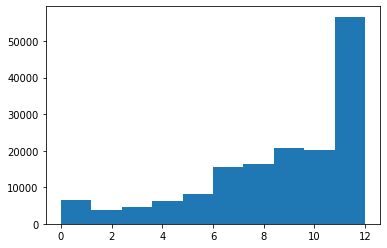

In [99]:
plt.hist(no_booking_mth['no_months'])

In [100]:
# Export dataset of listings and number of zero-booking months
# no_booking_mth.to_csv(r'no_booking_listings.csv', index=False)

## Merge datasets
(1) Merge listings and low_occ to characterise the listings with low booking rates  
(2) Merge econ_stat and low_occ to characterise months with low booking rates?

### Merge listings and low_occ

In [125]:
listings.head()

,accommodates,amenities,availability_30,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,has_availability,...,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value,room_type,state,weekly_price,zipcode
0,2.0,"{""Cable TV"",""Wireless Internet"",""Air condition...",24,1.0,Real Bed,1.0,1.0,moderate,sunnysidebronx,NaN,...,10.0,10.0,10.0,10.0,100.0,10.0,Private room,NY,NaN,10464
1,4.0,"{TV,Internet,""Wireless Internet"",""Air conditio...",30,1.0,Real Bed,1.0,1.0,flexible,sunnysidebronx,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Private room,NY,NaN,10464
2,4.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",30,3.0,Real Bed,3.0,3.0,strict,sunnysidebronx,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Entire home/apt,NY,NaN,10464
3,3.0,"{TV,Internet,""Wireless Internet"",""Air conditio...",8,1.0,Real Bed,1.0,1.0,strict,long island city,NaN,...,10.0,10.0,10.0,10.0,93.0,10.0,Entire home/apt,NY,775.0,10464
4,4.0,"{Internet,""Wireless Internet"",""Air conditionin...",17,1.0,Real Bed,1.0,1.0,moderate,sunnysidebronx,NaN,...,10.0,10.0,10.0,10.0,97.0,10.0,Private room,NY,350.0,10464


In [87]:
print(listings.columns)

Index(['accommodates', 'amenities', 'availability_30', 'bathrooms', 'bed_type',
       'bedrooms', 'beds', 'cancellation_policy', 'city', 'has_availability',
       'host_id', 'id', 'instant_bookable', 'latitude', 'longitude',
       'metropolitan', 'name', 'price', 'property_type',
       'review_scores_checkin', 'review_scores_cleanliness',
       'review_scores_communication', 'review_scores_location',
       'review_scores_rating', 'review_scores_value', 'room_type', 'state',
       'weekly_price', 'zipcode'],
      dtype='object')


In [149]:
# Filter only listings in New York
listings_new = listings[listings['state']=='NY'] 

# Drop unnecessary columns
listings_new = listings_new.drop(['has_availability','availability_30','host_id','name','weekly_price','state'],axis=1)

In [150]:
listings_new.head()

,accommodates,amenities,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,id,instant_bookable,...,price,property_type,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value,room_type,zipcode
0,2.0,"{""Cable TV"",""Wireless Internet"",""Air condition...",1.0,Real Bed,1.0,1.0,moderate,sunnysidebronx,7949480,f,...,99.0,House,10.0,10.0,10.0,10.0,100.0,10.0,Private room,10464
1,4.0,"{TV,Internet,""Wireless Internet"",""Air conditio...",1.0,Real Bed,1.0,1.0,flexible,sunnysidebronx,16042478,t,...,200.0,Apartment,NaN,NaN,NaN,NaN,NaN,NaN,Private room,10464
2,4.0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",3.0,Real Bed,3.0,3.0,strict,sunnysidebronx,1886820,f,...,300.0,House,NaN,NaN,NaN,NaN,NaN,NaN,Entire home/apt,10464
3,3.0,"{TV,Internet,""Wireless Internet"",""Air conditio...",1.0,Real Bed,1.0,1.0,strict,long island city,6627449,f,...,125.0,Apartment,10.0,10.0,10.0,10.0,93.0,10.0,Entire home/apt,10464
4,4.0,"{Internet,""Wireless Internet"",""Air conditionin...",1.0,Real Bed,1.0,1.0,moderate,sunnysidebronx,5557381,t,...,69.0,House,10.0,10.0,10.0,10.0,97.0,10.0,Private room,10464


In [92]:
# KIV

occupancy_yr = calendar.groupby([pd.Grouper(key='date',freq='Y'),'listing_id'])['available'].sum().to_frame()
occupancy_yr = occupancy_yr.reset_index()
occupancy_yr.head()

,date,listing_id,available
0,2017-12-31,2515,185
1,2017-12-31,2595,244
2,2017-12-31,3647,244
3,2017-12-31,3831,41
4,2017-12-31,4611,118
